In [2]:
%matplotlib inline
import slug
import os
import glob
import h5py
import yaml

import numpy as np

import matplotlib.pyplot as plt

from kungpao import io
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

from astropy.io import fits
from astropy import wcs
from astropy.table import Table, Column

from scipy import interpolate
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

plt.rc('axes', titlepad=20)

In [7]:
# Import catalog of MUSE
obj_cat = Table.read('./Catalog/s18a_z0.10_0.15_rcmod_16.0_17.5_etg_muse_sbp.fits', format='fits')

In [3]:
# Import sky-obj catalog. This takes some time.
sky_cat = Table.read('./Catalog/s18a_wide_skyobject_use_meas.fits', format='fits')

## Open HDF5 files

This HDF5 contains: 
Image
Image/i-band
Image/i-band/image
Image/i-band/image_header
Image/i-band/mask
Image/i-band/mask_header
Image/i-band/variance
Image/i-band/variance_header
Mask
Mask/i-band
ell_fix
ell_fix/i-band
ell_free
ell_free/i-band
info


Info contains:  ['redshift', 'mean_pa', 'mean_e', 'i-band-global-rms', 'i-band-global-bkg', 'size(pix)', 'edition', 'bad_mask', 'ra', 'dec']


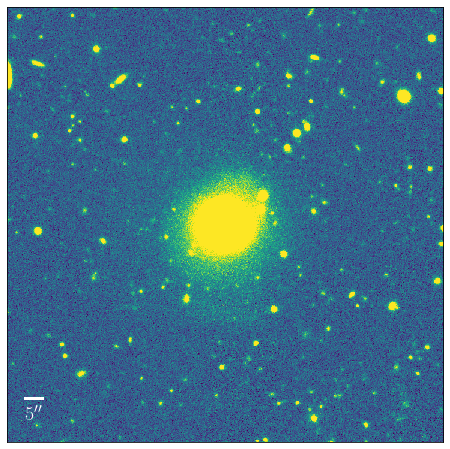

In [12]:
for obj in obj_cat[0:1]:
    path = './HDF5/'
    prefix = 'HSC-MUSE-'+ ("%04d" % obj['row_index']) + '-objid-' + str(obj['object_id'])
    filename = path + prefix + '.h5'
    
    # Open file
    f = h5py.File(filename, 'r')
    print('This HDF5 contains: ')
    slug.h5_print_attrs(f)
    print('\n')
    
    # Load Image and mask
    img = f['Image/i-band/image'].value
    msk = f['Mask/i-band'].value
    
    # Load info of this galaxy
    info = slug.str2dic(f['info'].value)
    print("Info contains: ", list(info.keys()))
    redshift = info['redshift']
    ra, dec = info['ra'], info['dec']
    
    # Close file
    f.close()
    
    # Show the image
    display_single(img);

## Play with `ELLIPSE` isophotes. 

If `info[bad_mask]==1`, it means `ELLIPSE` failed because of bad mask. If `np.any(np.array(list(f.keys()) == 'ell_fix')` is False, it means `ELLIPSE` failed because of other issues. But in this new catalog (`s18a_z0.10_0.15_rcmod_16.0_17.5_etg_muse_sbp.fits`), I excluded all those galaxies with issues.

I subtract `skyobj` on the profile level, using
```
off_set = slug.skyobj_value(sky_cat, ra, dec, matching_radius=[1, 3], 
                                aperture='84', iters=5, showmedian=False)```

Info contains:  ['redshift', 'mean_pa', 'mean_e', 'i-band-global-rms', 'i-band-global-bkg', 'size(pix)', 'edition', 'bad_mask', 'ra', 'dec']


NameError: name 'sky_cat' is not defined

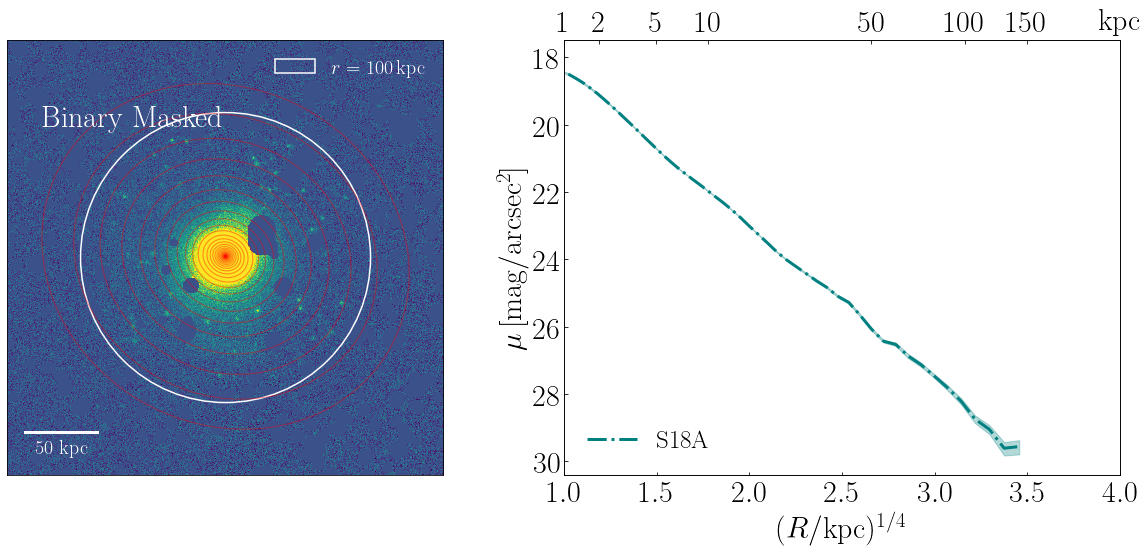

In [16]:
for obj in obj_cat[0:1]:
    path = './HDF5/'
    prefix = 'HSC-MUSE-'+ ("%04d" % obj['row_index']) + '-objid-' + str(obj['object_id'])
    filename = path + prefix + '.h5'
    # Open file
    f = h5py.File(filename, 'r')
    # Load Image and mask
    img = f['Image/i-band/image'].value
    msk = f['Mask/i-band'].value
    # Load info of this galaxy
    info = slug.str2dic(f['info'].value)
    print("Info contains: ", list(info.keys()))
    redshift = info['redshift']
    ra, dec = info['ra'], info['dec']
    # Load ELLIPSE isophotes in `fix` mode
    ell_fix = f['ell_fix/i-band'].value
    # Close file
    f.close()
    
    
    
        
    # Plot figures
    fig = plt.figure(figsize=(20, 8))
    grid = plt.GridSpec(1, 10, wspace=0.05, hspace=0.1)
    
    ## Show isophotes
    ax1 = fig.add_subplot(grid[0, 0:4])
    ax1 = slug.display_isophote(img*(~msk), ell_fix, slug.HSC_pixel_scale,
                        text='Binary\ Masked', circle=[100], ax=ax1,
                        physical_scale=slug.phys_size(info['redshift'], is_print=False))
    
    ## Show SBP
    ax2 = fig.add_subplot(grid[0, 5:])
    ax2.tick_params(direction='in')
    slug.SBP_single(ell_fix, redshift, slug.HSC_pixel_scale, slug.HSC_zeropoint, ax=ax2, offset=-0,
        physical_unit=True, x_max=4.0, vertical_line=None, show_dots=False, linecolor='teal',
        linestyle='-.', label="S18A")

    ## Calculate the mean value of `skyobjects`
    off_set = slug.skyobj_value(sky_cat, ra, dec, matching_radius=[1, 3], 
                                aperture='84', iters=5, showmedian=False)
    print('Offset: ', off_set)

    slug.SBP_single(ell_fix, redshift, slug.HSC_pixel_scale, slug.HSC_zeropoint, ax=ax2, offset=-off_set,
        physical_unit=True, x_max=4.0, vertical_line=None, show_dots=False, linecolor='firebrick',
        linestyle='-', label="S18A\ sky\ objects")
    ax2.invert_yaxis()
        
    plt.subplots_adjust(wspace=0.)
    plt.suptitle(prefix, fontsize=30, color='blue')
    
    #plt.savefig('./Figures/SBP-' + prefix + '.png', dpi=100, bbox_inches='tight')
    #plt.close()